In [1]:
import os
import datetime as dt
from matplotlib.ticker import AutoMinorLocator, NullFormatter
import numpy as np
import pandas as pd
import statsmodels as sm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, MaxPooling2D, BatchNormalization, \
    TimeDistributed, Reshape, Flatten, Dense, Dropout, LSTM, Conv1D, Conv2D
from tensorflow.keras.callbacks import TensorBoard
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

import tensorflow as tf
import tensorboard as tb
from tensorflow.keras.callbacks import TensorBoard
import matplotlib_inline
from matplotlib import pyplot as plt

# set styles
%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.style.use('/kaggle/input/proplot-stylesheet/proplot_style.mplstyle')

# set paths to data sources
BASE_PATH = '/kaggle/input/eit-touch-sensor-datasets'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_sd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_6_fingers - SD.xlsx', sheet_name='Voltages')
y_sd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_6_fingers - SD.xlsx', sheet_name='Configuration')

X_sd = StandardScaler().fit_transform(X_sd)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 reshape (Reshape)           (None, 1, 32, 32)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 32, 32)        1632      
                                                                 
 batch_normalization (BatchN  (None, 96, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        7

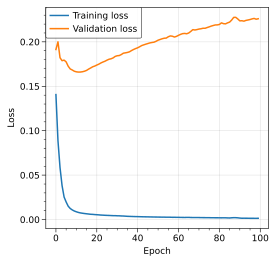

4/4 [==============================] - 0s 3ms/step - loss: 0.0666
{'conv_1': 96, 'units_2': 4, 'conv_2': 16, 'units_3': 10}
0.06661555171012878


In [13]:
# 80 : 10 : 10
X_train, X_test, y_train, y_test = train_test_split(X_sd, y_sd, test_size=1/10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9)

# 768-64-64-6, sigmoid, binary_crossentropy, val_loss - best for training
# 256-192-196-6, sigmoid, binary_crossentropy, val_loss - best for testing

def build_6_cnn_model(hp: HyperParameters) -> Sequential:
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(1024,)))
    model_cnn.add(Dense(units=1024))  # encoder
    model_cnn.add(Reshape((-1, 32, 32)))
    model_cnn.add(Conv2D(filters=hp.Int('conv_1', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Int('units_2', min_value=3, max_value=7, step=1),
                         activation='relu', padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(filters=hp.Int('conv_2', min_value=16, max_value=64, step=16),
                         kernel_size=hp.Int('units_3', min_value=7, max_value=11, step=1),
                         activation='relu', padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32), activation='relu'))  # decoder
    model_cnn.add(Dense(units=6, activation='sigmoid'))
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy')
    model_cnn.summary()
    return model_cnn

def build_6_cnn_model_simple() -> Sequential:
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(1024,)))
    model_cnn.add(Dense(units=1024))  # encoder
    model_cnn.add(Reshape((-1, 32, 32)))
    model_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu',
                         padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(filters=64, kernel_size=7, activation='relu',
                         padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(units=128, activation='relu'))  # decoder
    model_cnn.add(Dense(units=6, activation='sigmoid'))
    model_cnn.compile(optimizer='adam', loss='mse')
    model_cnn.summary()
    return model_cnn

tuner = BayesianOptimization(build_6_cnn_model, objective='val_loss', max_trials=10)
    #directory='tuner_dir', project_name='my_tuner_6_dof')

# find best hyperparameters - use 100 epochs instead of 200 to save time
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

#best_model = build_6_cnn_model_simple()

# train best model
best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=128,
                              validation_data=(X_val, y_val))
plt.plot(best_history.history['loss'], label='Training loss')
plt.plot(best_history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_graph.svg')
plt.show()

# test best model
best_loss = best_model.evaluate(X_test, y_test)
print(best_hyperparameters.values)
print(best_loss)

# save best model
best_model.save('/kaggle/working/cnn_6_finger.keras')

1/1 [==============================] - 0s 27ms/step


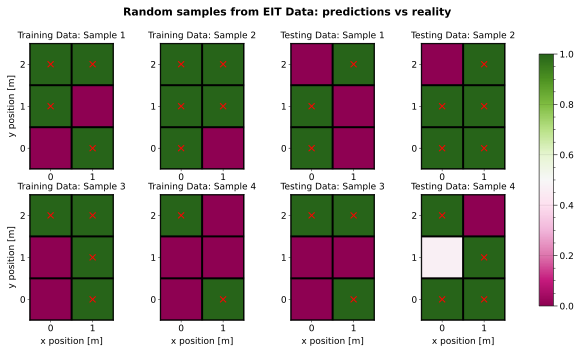

4/4 [==============================] - 0s 3ms/step
Proportion (training): 99.96212121212122%
Proportion (testing): 97.57575757575758%
Fully correct (training): 99.77272727272727%
Fully correct (testing): 89.0909090909091%


In [14]:
model_6 = load_model('/kaggle/working/cnn_6_finger.keras', compile=False)

# take 4 random samples from each of the training and testing datasets
samples_i = np.random.randint(X_train.shape[0], size=4)
X_sample_train = X_train[samples_i]
y_sample_train = y_train.values[samples_i]
y_pred_train = model_6.predict(X_sample_train)
samples_i = np.random.choice(X_test.shape[0], 4, replace=False)
X_sample_test = X_test[samples_i]
y_sample_test = y_test.values[samples_i]
y_pred_test = model_6.predict(X_sample_test)
y_sample_train, y_sample_test = np.array(y_sample_train), np.array(y_sample_test)
mapping = {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2)}
config_to_xy = lambda arr: np.array([[mapping[i] for i in indices] for indices in [np.where(row == 1.0)[0] for row in arr]], dtype=object)
config_to_arr = lambda arr: np.array([[[conf[0], conf[3]], [conf[1], conf[4]], [conf[2], conf[5]]] for conf in arr])
y_sample_train_arr = config_to_xy(y_sample_train)
y_sample_test_arr = config_to_xy(y_sample_test)
y_pred_train_arr = config_to_arr(y_pred_train)
y_pred_test_arr = config_to_arr(y_pred_test)

# plot results
GRID_DIV_X, GRID_DIV_Y = 2, 3
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle('Random samples from EIT Data: predictions vs reality')
ax_trains = axs[:, :2].flatten()
ax_tests = axs[:, 2:].flatten()
cbar_upper_lim = min(1, 1 * np.max(y_pred_train))

for i, ax_train in enumerate(ax_trains):
    ax_train.set_title(f'Training Data: Sample {i + 1}')
    if i in (2, 3):
        ax_train.set_xlabel('x position [m]')
    if i in (0, 2):
        ax_train.set_ylabel('y position [m]')
    ax_train.set_xlim([0, 1])
    ax_train.set_ylim([0, 2])
    ax_train.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_train.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_train.tick_params(which='major', size=0, labelsize=0)
    ax_train.xaxis.set_major_formatter(NullFormatter())
    ax_train.yaxis.set_major_formatter(NullFormatter())
    ax_train.xaxis.set_minor_formatter('{x:.0f}')
    ax_train.yaxis.set_minor_formatter('{x:.0f}')
    ax_train.set_xticks(np.arange(-0.5, GRID_DIV_X + 0.5, 1))
    ax_train.set_yticks(np.arange(-0.5, GRID_DIV_Y + 0.5, 1))
    ax_train.imshow(y_pred_train_arr[i], cmap='PiYG', vmin=0, vmax=1)
    ax_train.plot(*zip(*y_sample_train_arr[i]), 'rx')
            
for i, ax_test in enumerate(ax_tests):
    ax_test.set_title(f'Testing Data: Sample {i + 1}')
    if i in (2, 3):
        ax_test.set_xlabel('x position [m]')
    ax_test.set_xlim([0, 1])
    ax_test.set_ylim([0, 2])
    ax_test.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_test.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_test.tick_params(which='major', size=0, labelsize=0)
    ax_test.xaxis.set_major_formatter(NullFormatter())
    ax_test.yaxis.set_major_formatter(NullFormatter())
    ax_test.xaxis.set_minor_formatter('{x:.0f}')
    ax_test.yaxis.set_minor_formatter('{x:.0f}')
    ax_test.set_xticks(np.arange(-0.5, GRID_DIV_X + 0.5, 1))
    ax_test.set_yticks(np.arange(-0.5, GRID_DIV_Y + 0.5, 1))
    if i == 3:
        im = ax_test.imshow(y_pred_test_arr[i], cmap='PiYG', vmin=0, vmax=1)
    else:
        ax_test.imshow(y_pred_test_arr[i], cmap='PiYG', vmin=0, vmax=1)
    ax_test.plot(*zip(*y_sample_test_arr[i]), 'rx')

for ax in axs.flatten():
    ax.grid(linewidth=2, visible=True, which='major', alpha=1.0)
    ax.grid(which='minor', alpha=0.0)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('/kaggle/working/sol.svg')
plt.show()

# Calculate what proportion of square are correct
def calc_prop_correct_squares(y_test: np.ndarray, y_pred: np.ndarray) -> float:
    y_pred_rounded = np.round(y_pred).astype(int)
    return np.mean([np.sum(y1 == y2) / 6 for y1, y2 in zip(y_test, y_pred_rounded)])

def calc_prop_fully_correct(y_test: np.ndarray, y_pred: np.ndarray) -> float:
    y_pred_rounded = np.round(y_pred).astype(int)
    return np.mean([int(np.array_equal(y1, y2)) for y1, y2 in zip(y_test, y_pred_rounded)])

y_pred_train = model_6.predict(X_train)
y_pred_test = model_6.predict(X_test)
print(f'Proportion (training): {100 * calc_prop_correct_squares(y_train.values, y_pred_train)}%')
print(f'Proportion (testing): {100 * calc_prop_correct_squares(y_test.values, y_pred_test)}%')
print(f'Fully correct (training): {100 * calc_prop_fully_correct(y_train.values, y_pred_train)}%')
print(f'Fully correct (testing): {100 * calc_prop_fully_correct(y_test.values, y_pred_test)}%')